**Notebook Description:**

HDBSCAN identify clusters in high density zone where datapoints have strong linkage.
Noteworthy, samples in sparse zone or with weak linkage won't be assigned to any clusters.
HDBSCAN can self-determine the optiaml number of clusters, so users don't need to pre-define the number of clusters.

More info of HDBSCAN can be found at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

Note: HDBSCAN algorithm only available in scikit-learn version later than 1.3. </br>
`pip install scikit-learn==1.3`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import HDBSCAN

from distinctipy import distinctipy

plt.style.use('fivethirtyeight')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r6okgm9a because the default path (/home/users/vtang/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Load data

Sentinel-1 time series and t-SNE 2D datapoints

In [2]:
# load t-SNE 2D data points
df_ebd = pd.read_csv(f'data/tsne2d_2022.csv', index_col=0)

# load senitnel-1 time series
df_bts = pd.read_csv(f'data/vh_2022.csv', index_col=0)

# Cluster Analysis - HDBSCAN

- samples not assigned to any clusters will have a label of -1

In [3]:
hdbscan = HDBSCAN(
    min_cluster_size=200,
    min_samples=10,
    max_cluster_size=1000,
    cluster_selection_epsilon=.0,
    cluster_selection_method='leaf',
)
hdbscan.fit(df_ebd.values)

n_class = len(np.unique(hdbscan.labels_))
print('Number of clusters:', n_class)

Number of clusters: 15


## Save cluster labels

In [4]:
def convert_class_code_to_name(class_codes):
    class_names = ['Class {}'.format(i + 1) for i in class_codes]
    class_names = ['No Label' if item == 'Class 0' else item for item in class_names]
    return class_names

In [5]:
df_lab = pd.DataFrame(hdbscan.labels_, index=df_ebd.index, columns=['label'])
df_lab['label'] = convert_class_code_to_name(df_lab['label'].values)
df_lab.to_csv(f'data/hdbscan_label_2022.csv')

# Plotting

sampels with no label show in grey colors

In [6]:
colors = [(0.7, 0.7, 0.7)]
colors += distinctipy.get_colors(n_class - 1)

## Plot t-SNE datapoints with cluster labels

<AxesSubplot:xlabel='x', ylabel='y'>

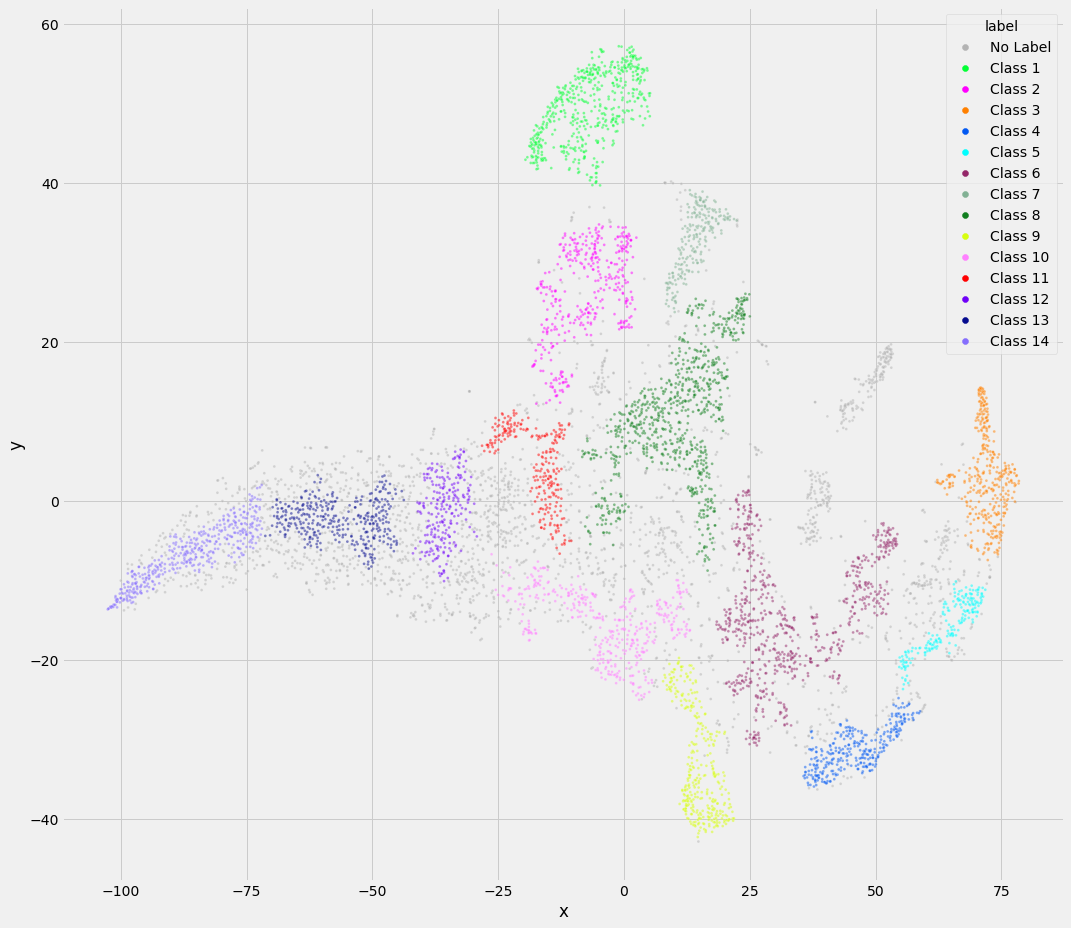

In [7]:
df_pt = df_ebd.copy()
df_pt['label'] = hdbscan.labels_
df_pt = df_pt.sort_values('label')

# convert cluster code to label
df_pt['label'] = convert_class_code_to_name(df_pt['label'].values)

fig, ax = plt.subplots(figsize=[16, 15])
sns.scatterplot(
    data=df_pt, x='x', y='y', hue='label',
    alpha=0.5, s=8, palette=colors, ax = ax,
)

## Plot time series with cluster labels

In [8]:
df_ts = df_bts.copy()
df_ts.index = hdbscan.labels_
df_ts = df_ts.sort_index()

# convert cluster code to label
df_ts.index = convert_class_code_to_name(df_ts.index.values)

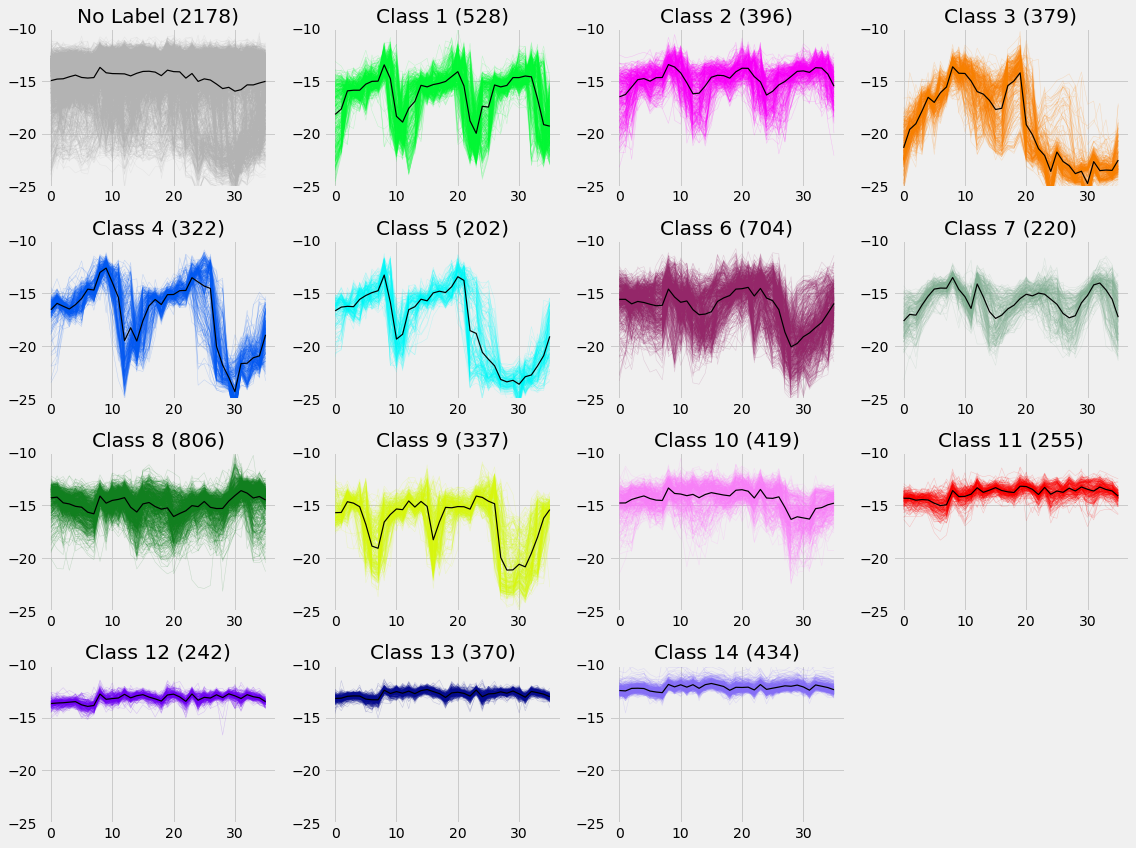

In [9]:
labels = df_ts.index.unique().values

ncol=4
nrow = int(n_class / ncol) + 1

fig = plt.Figure(figsize=[ncol * 4, nrow * 3])
gs = plt.GridSpec(nrow, ncol)

for i in range(n_class):

    target_label = labels[i]

    ts = df_ts.loc[target_label].values
    ts_avg = np.mean(ts, axis=0)

    ax = fig.add_subplot(gs[i])
    ax.plot(ts.T, color=colors[i], alpha=0.2, lw=0.5)
    ax.plot(ts_avg, color='k', lw=1.2)
    ax.set_title(target_label + ' ({})'.format(ts.shape[0]))
    ax.set_ylim([-25, -10])

fig.tight_layout()
fig